In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import re
from bs4 import BeautifulSoup
from scipy.sparse import hstack
from gensim.models import Doc2Vec, Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Exploration 

In [3]:
df = pd.read_excel('AI_Engineer_Dataset_Task_1.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180969 entries, 0 to 180968
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   AcademicYear         180969 non-null  int64 
 1   SemesterName         180969 non-null  object
 2   ParticipantID        180969 non-null  int64 
 3   DegreeLevel          180969 non-null  object
 4   Gender               180969 non-null  object
 5   Nationality          180969 non-null  object
 6   StudentProgram       180969 non-null  object
 7   CourseCode           180969 non-null  object
 8   CourseName           180969 non-null  object
 9   QuestionText         180969 non-null  object
 10  QuestionType         180969 non-null  object
 11  ParticipantResponse  168848 non-null  object
dtypes: int64(2), object(10)
memory usage: 16.6+ MB


In [5]:
df.ParticipantResponse.value_counts()

Strongly Agree                                                                                                                                        88689
Agree                                                                                                                                                 33665
Neutral                                                                                                                                               17639
Strongly Disagree                                                                                                                                     17226
Disagree                                                                                                                                               6391
                                                                                                                                                      ...  
No recommendations, very interesting and useful information for 

# Data Cleaning

Extracted rating info and User Comments from ParticipantResponse into seprate column of Rating and UserComments

In [6]:
df['rating'] = df.apply(lambda x: x['ParticipantResponse'] if x['QuestionType']=='Rating' else 'NaN', axis=1)

In [7]:
df['UserComment'] = df.apply(lambda x: x['ParticipantResponse'] if x['QuestionType']=='User Comment' else 'NaN', axis=1)

Making sure userComment column is string and lowercase 

In [9]:
df['UserComment'] = df['UserComment'].astype(str).str.lower()

Removing word "no" from the start of the sentence to avoid negative scoring

In [10]:
df['UserComment'] = df['UserComment'].str.replace(r'^(no,? )', '', regex=True)

In [42]:
# Fill NaN values with empty strings
df['ParticipantResponse'] = df['ParticipantResponse'].fillna('')

## Method for Calculating Sentiment Score of Text in UserComment

Using VADER SentimentIntensityAnalyser which is one the Method to caculate sentiment score.

In this method, we will use the Sentiment Intensity Analyser which uses the VADER Lexicon. VADER is a long-form for Valence Aware and sEntiment Reasoner, a rule-based sentiment analysis tool. VADER calculates text emotions and determines whether the text is positive, neutral or, negative. This analyzer calculates text sentiment and produces four different classes of output scores: positive, negative, neutral, and compound. A compound score is the aggregate of the score of a word, or precisely, the sum of all words in the lexicon, normalized between -1 and 1.


### Method Implementation

First, we will import the libraries. We will use the NLTK library for importing the SentimentIntensityAnalyzer.

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asifs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Next, we will create the instance of SentimentIntensityAnalyzer.

In [13]:
sent = SentimentIntensityAnalyzer()

Finally, we will calculate the Compound Poalrtity Score and add it into the Main DataFrame for each of the UserComment.

Note: Assigning unique score value of 2 to all userComment with word "no" to avoid negative scoring and this score will be used for Neutral sentiment determination at later stage.

In [14]:
polarity = []
for i in df['UserComment']:
    if i == "no":
        polarity.append(2.0)
    else:
        polarity.append(round(sent.polarity_scores(i)['compound'], 2))   

In [15]:
#add sentiment_score to the dataframe
df['sentiment_score'] = polarity

In [16]:
#checking negative score for negative comments
df.loc[df['sentiment_score'] < 0, ['UserComment', 'sentiment_score']]

,UserComment,sentiment_score
1438,in a way the prof was so strict and following ...,-0.83
1565,very very hard course,-0.24
1733,stop teaching at the level of a master. and ma...,-0.30
1777,he doesn't explain well,-0.21
2635,nothing all good,-0.34
...,...,...
173838,the chairs and tables in the rows are uncomfor...,-0.38
175998,i have a point on the instructor that in the v...,-0.16
176382,the chairs and tables in the rows are uncomfor...,-0.38
177630,the dr are dependent on youtu.be and many fram...,-0.10


In [17]:
df['rating'].value_counts()

Strongly Agree       88689
Agree                33664
Neutral              17623
NaN                  17344
Strongly Disagree    17226
Disagree              6391
Good                    32
Name: rating, dtype: int64

In [77]:
#setting conditions based on sentiment score and rating for overall sentiment determination
conditions = [
    ((df['sentiment_score'] < 0.0) | (df['rating'].isin(['Disagree', 'Strongly Disagree']))),
    ((df['sentiment_score'] > 0.0) | (df['rating'].isin(['Agree', 'Strongly Agree', 'Good']))),
    ((df['sentiment_score'] == 2.0) | (df['rating'] == 'Neutral'))
]

In [78]:
sentiments = ['negative', 'positive', 'neutral']

In [79]:
#applying conditions to dataframe
df['overall_sentiment'] = np.select(conditions, sentiments)

In [80]:
df

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse,rating,UserComment,id,sentiment_score,overall_sentiment,Topic
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,Disagree,Disagree,nan,1,0.0,negative,1
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,Strongly Disagree,Strongly Disagree,nan,2,0.0,negative,1
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,Strongly Disagree,Strongly Disagree,nan,3,0.0,negative,1
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,Strongly Disagree,Strongly Disagree,nan,4,0.0,negative,1
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,Strongly Disagree,Strongly Disagree,nan,5,0.0,negative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180964,2021,Spring 2021 - 2022,7040334533,Bachelor,Male,India,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,Do you have any recommendations or suggestions...,User Comment,,NaN,nan,180965,0.0,0,0
180965,2021,Spring 2021 - 2022,6724000467,Bachelor,Male,United Arab Emirates,Bachelor of Arts in Security and Strategic Stu...,TOL 200,Tolerance and Diversity,CLO : analyze the relationship between diversi...,Rating,Agree,Agree,nan,180966,0.0,positive,4
180966,2022,Fall 2022 - 2023,6373669933,Bachelor,Male,United Kingdom,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,The faculty discussed the course syllabus at t...,Rating,Strongly Agree,Strongly Agree,nan,180967,0.0,positive,4
180967,2022,Fall 2022 - 2023,6373669933,Bachelor,Male,United Kingdom,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,The coursework and assignments are challenging,Rating,Strongly Agree,Strongly Agree,nan,180968,0.0,positive,4


In [146]:
14846/len(df['ParticipantResponse'])*100

8.203614983781753

we use bar plot to compare the total number of each type of sentiments 

In [116]:
sentiments_count = df.groupby('overall_sentiment').size().reset_index(name='Count')

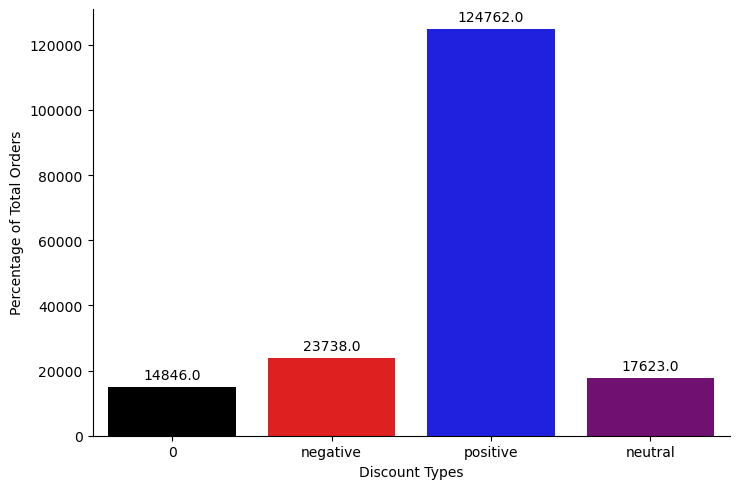

In [133]:
import seaborn as sns

cols = {'0': 'black', 'negative': 'red', 'positive': 'blue', 'neutral': 'purple'}

ax = sns.catplot(kind="count",
            data=df,
            x="overall_sentiment",
            order = ["0", "negative", "positive", "neutral"],
            height=5,
            aspect=1.5,
            palette = cols,
            errorbar=None)
                #  color = cols);
g = ax.facet_axis(0,0)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
ax.set(xlabel = 'Discount Types', ylabel = 'Percentage of Total Orders')

We define years and performance values for each type of sentiments.
We use Matplotlib to create the line chart, plotting count of each sentiment's over the years.
We add labels for the x-axis and y-axis, a title for the chart, and a legend to distinguish the categories.
Finally, we display the plot using plt.show().

In [81]:
result = df.groupby(['AcademicYear', 'overall_sentiment']).size().reset_index(name='Count')

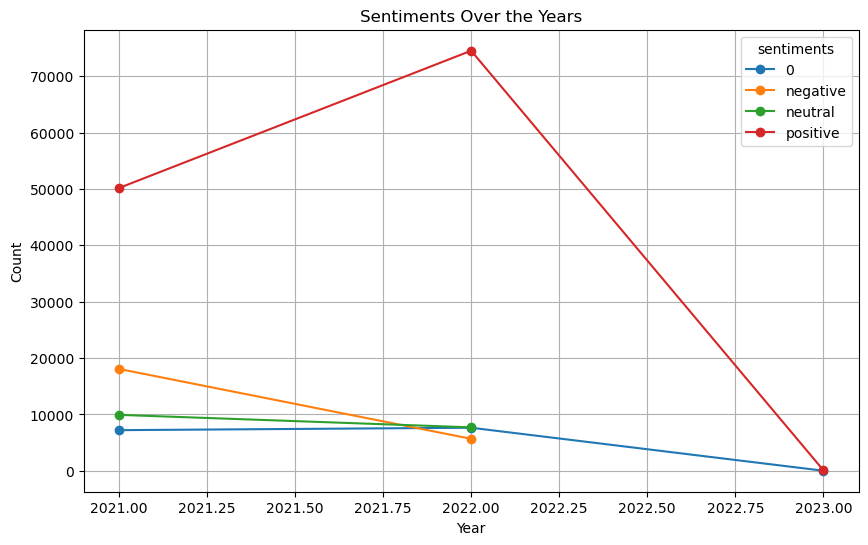

In [82]:
# Pivot the table to have categories as columns
pivot_table = result.pivot(index='AcademicYear', columns='overall_sentiment', values='Count')

# Plot a line graph for each category
import matplotlib.pyplot as plt
pivot_table.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Sentiments Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='sentiments')
plt.show()

# Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is used as a modelling technique that can classify text in a document to a particular topic. It uses Dirichlet distribution to find topics for each document model and words for each topic model.

### Implementation

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(df['ParticipantResponse'])

### LDA Model

In [44]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [45]:
vocab = cv.get_feature_names_out()

### Showing Stored Words:

In [151]:
for i in range(10):
    random_word_id = random.randint(0,1954)
    print(vocab[random_word_id])

health
انا
3d
ease
examples
تحياتي
كلاس
فهي
based
يسر


In [152]:
for i in range(10):
    random_word_id = random.randint(0,1954)
    print(vocab[random_word_id])

تعرف
uncomfortable
اثناء
معها
تعلمت
نو
errors
عدد
recommendation
تعلمت


### Showing top words per topic

In [49]:
len(LDA.components_)

7

In [50]:
len(LDA.components_[0])

1954

In [51]:
single_topic = LDA.components_[0]

In [52]:
# Returns the indices that would sort this array.
single_topic.argsort()

array([1087, 1911, 1536, ...,  341,  223,  168], dtype=int64)

In [53]:
# Top 10 words for this topic:
single_topic.argsort()[-10:]

array([795, 128, 635,  37, 751, 215,  89, 341, 223, 168], dtype=int64)

In [149]:
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names_out()[index])

thanks
class
really
amazing
students
doctor
best
great
dr
course


We will perform .transform() on our vectorized UserComments to attach a label number. But before, we view all the topics found.

In [55]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['lot', 'courses', 'professor', 'clear', 'instructor', 'thanks', 'class', 'really', 'amazing', 'students', 'doctor', 'best', 'great', 'dr', 'course']


THE TOP 15 WORDS FOR TOPIC #1
['الوسائل', 'survey', 'par', 'hello', 'shahad', 'thankyou', 'لاشي', 'noooo', 'بشده', 'اوافق', 'kk', 'thankz', 'nope', 'strongly', 'disagree']


THE TOP 15 WORDS FOR TOPIC #2
['ممتاز', 'افضل', 'بشكل', 'دكتور', 'الطالب', 'ان', 'perfect', 'المساق', 'جدا', 'كل', 'الدكتور', 'المادة', 'على', 'من', 'في']


THE TOP 15 WORDS FOR TOPIC #3
['كلا', 'suggestion', 'lessons', 'dr', 'توجد', 'الماده', 'does', 'لايوجد', 'understand', 'recommendations', 'thank', 'يوجد', 'شكرا', 'good', 'لا']


THE TOP 15 WORDS FOR TOPIC #4
['going', 'fine', 'right', 'prepare', 'prior', 'far', 'consumed', 'showing', 'modern', 'number', 'statements', 'survey', 'nth', 'strongly', 'agree']


THE TOP 15 WORDS FOR TOPIC #5
['queries', 'hi', 'felt', 'arafat', 'evaluation', 'international', 'لمحاضر', 'والازدهار', 'الامتن

### Attaching Discovered Topic Labels to Original Articles

In [56]:
topic_results = LDA.transform(dtm)
df['Topic'] = topic_results.argmax(axis=1)

In [67]:
df.loc[df['ParticipantResponse'].str.contains("doctor"), ['ParticipantResponse', 'sentiment_score', 'Topic']]

,ParticipantResponse,sentiment_score,Topic
2783,Nothing but a good doctor who explains the cou...,-0.75,0
2800,i wish that the doctor do more than just readi...,0.68,0
8489,Amazing doctor,0.59,0
16656,I really liked the course sooo much and doctor...,0.91,0
18186,I believe the recommendations and suggestions ...,0.96,0
...,...,...,...
176820,the kindest doctor,0.00,0
176911,best doctor,0.64,0
178312,The best doctor,0.64,0
178415,The doctor have a vary uniq way to make me und...,0.44,0


In [148]:
df.loc[(df['ParticipantResponse'].str.contains("suggestion")), ['ParticipantResponse', 'sentiment_score', 'Topic']]

,ParticipantResponse,sentiment_score,Topic
930,no suggestions,0.00,0
2405,no suggestions,0.00,0
3440,The suggestion is to be having in-class work,0.00,0
7839,no suggestions,0.00,0
18186,I believe the recommendations and suggestions ...,0.96,0
19973,No suggestions,0.00,0
21891,No recommendations or suggestions. Everything ...,0.27,0
33998,I don't have any recommendations or suggestions.,0.00,0
35533,No suggestions.,0.00,0
36419,I don't have any suggestions due to the doctor...,0.51,0
